the goal here is to demonstrate how to run the add_fakelss function. we will pass a galaxy density map (based on simulated galaxy spectra in `../data/gcls.txt`) to which the function will add fake LSS (using `../data/fakelss_baseline-v1.4_nside1024.npz`).

In [1]:
import numpy as np
import healpy as hp
import os

In [2]:
import sys
sys.path.append('../code/')

from settings import *
from add_fakelss import add_fakelss
from utils_plot import plot_skymap

In [3]:
# path for the fakelss map
fakelss_map_path = '../data/fakelss_baseline-v1.4_nside1024.npz'

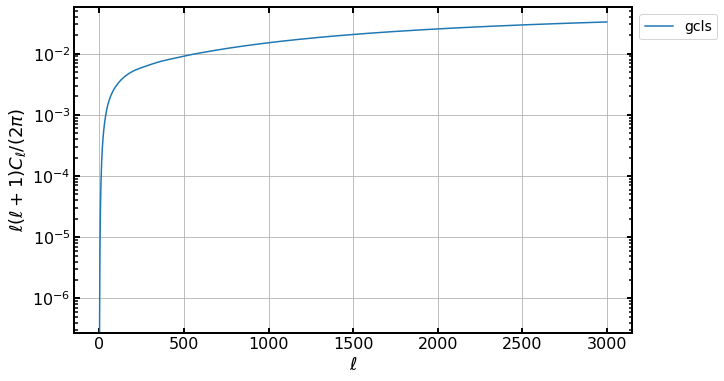

In [4]:
# set up the theory galaxy specturm
gcls = np.genfromtxt('../data/gcls.txt')
# extract the ells
ells = gcls[:, 0]
# extract the cells (i think this is right)
cls = gcls[:, 1]

# plot spectrum
plt.clf()
plt.plot(ells, (cls * ells * (ells+1)) / 2.0 / np.pi, label='gcls')
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_\ell/(2\pi)$')
plt.gca().set_yscale('log')
plt.show()

/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v2/envs/desc/lib/python3.7/site-packages/healpy/sphtfunc.py:400: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning,


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


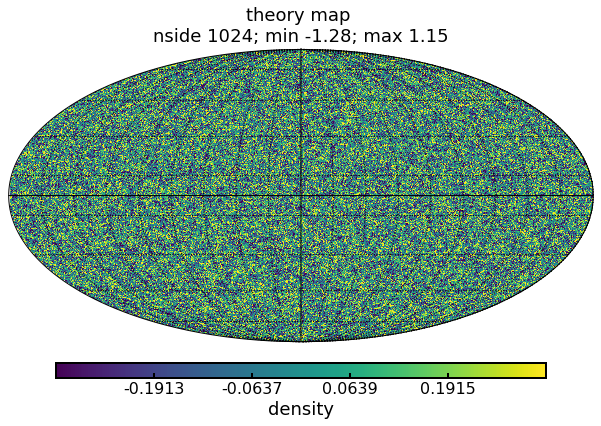

In [5]:
# now realize a density map using the spectrum
nside = 1024
theory_map = hp.synfast(cls, nside=nside)

# plot
plot_skymap(map_in=theory_map, title='theory map', file_tag=None,
            data_label='density', outdir=None,
            save_plot=False, show_plot=True)

## saved skymap_density_input-theory-density_nside1024.png


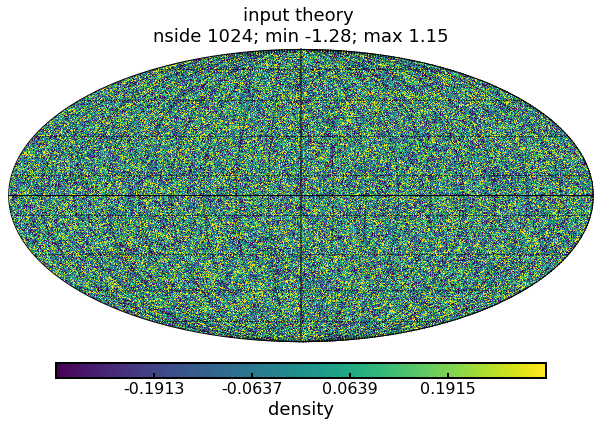

## saved power-spec_input-theory-density.png


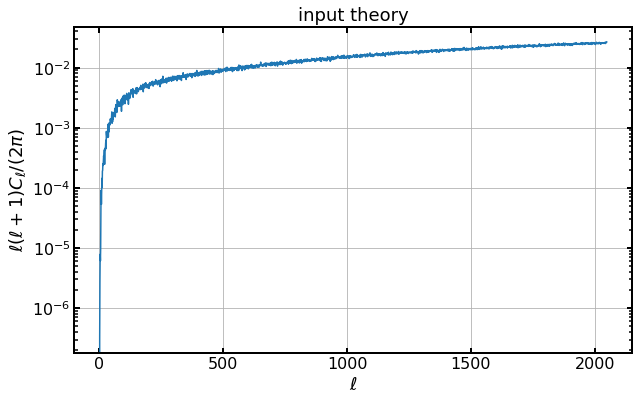

## saved skymap_density_readin-fakelss_nside1024.png


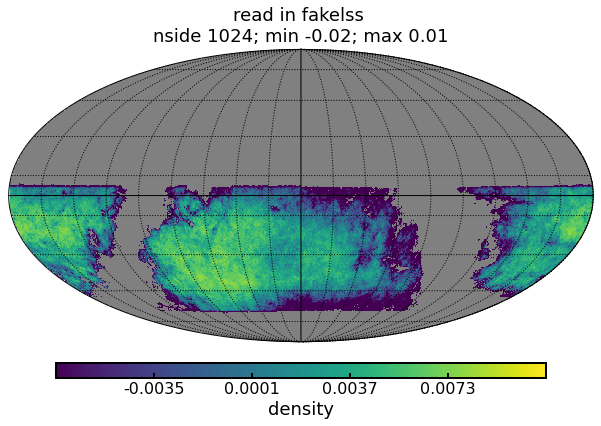

## saved power-spec_readin-fakelss.png


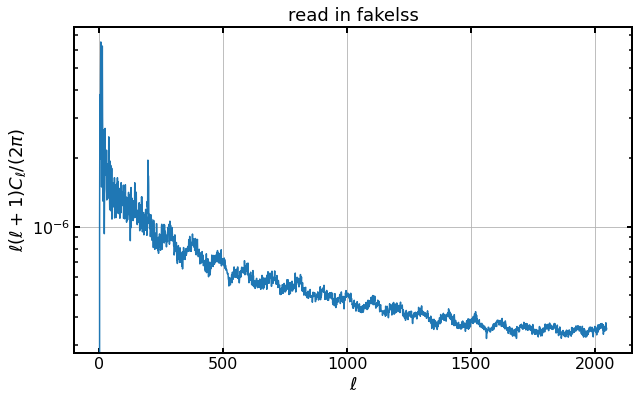

## saved skymap_density_theory+fakelss_nside1024.png


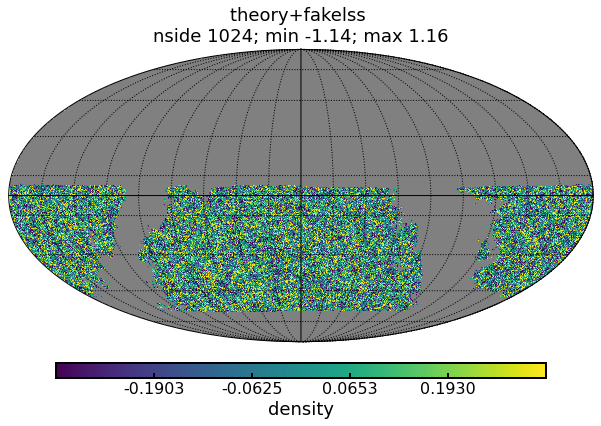

## saved power-spec_theory+fakelss.png


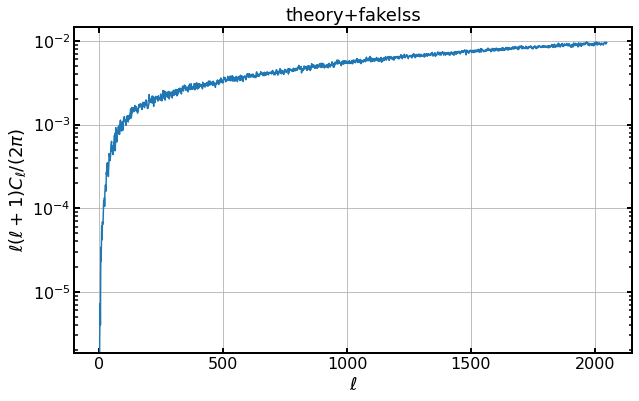

In [6]:
# set up the outdir
os.makedirs('test', exist_ok=True)

# okay now run the function
new_map = add_fakelss(theory_density_map=theory_map, fakelss_map_path=fakelss_map_path,
                      show_plot=True, save_plot=True, outdir='test')

lets plots things out for comparisons

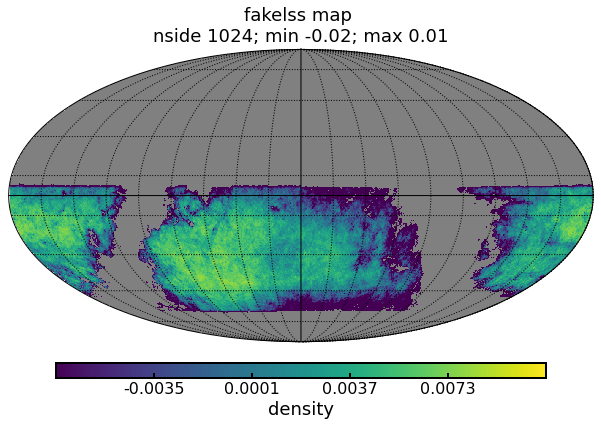

In [7]:
# lets read in the fakelss map
fakelss = np.load(fakelss_map_path)

# plot skymap
plot_skymap(map_in=fakelss['data'], title='fakelss map', file_tag=None,
            data_label='density', outdir=None,
            save_plot=False, show_plot=True)

In [8]:
lmax = int(nside * 2)
cls_theory = hp.anafast(theory_map, lmax=lmax)
cls_fakelss = hp.anafast(fakelss['data'], lmax=lmax)
cls_newmap = hp.anafast(new_map, lmax=lmax)

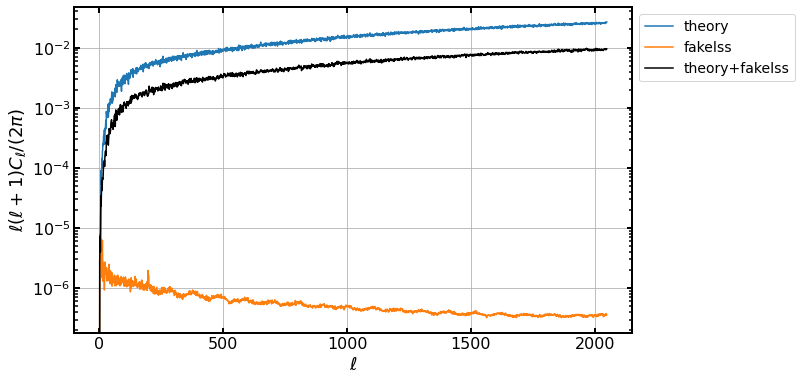

In [9]:
ells = np.arange(np.size(cls_fakelss))

# plot
plt.clf()
# theory spectrum
plt.plot(ells, (cls_theory * ells * (ells+1)) / 2.0 / np.pi, label='theory')
# fakelss spectrum
plt.plot(ells, (cls_fakelss * ells * (ells+1)) / 2.0 / np.pi, label='fakelss')
# new spectrum
plt.plot(ells, (cls_newmap * ells * (ells+1)) / 2.0 / np.pi, color='k', label='theory+fakelss')
# plot details
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_\ell/(2\pi)$')
plt.gca().set_yscale('log')
plt.show()

it makes sense that the black curve is offset from the blue, since the former is not using the full sky.

lets confirm that the final spectrum (black curve) makes sense. we know, based on [awan+2016](https://arxiv.org/pdf/1605.00555.pdf), that the final spectrum should be a linear sum of the theory spectrum and the fakelss spectrum (but only when considering the average spectra). we'll also plot things so that everything is effectively for full sky.

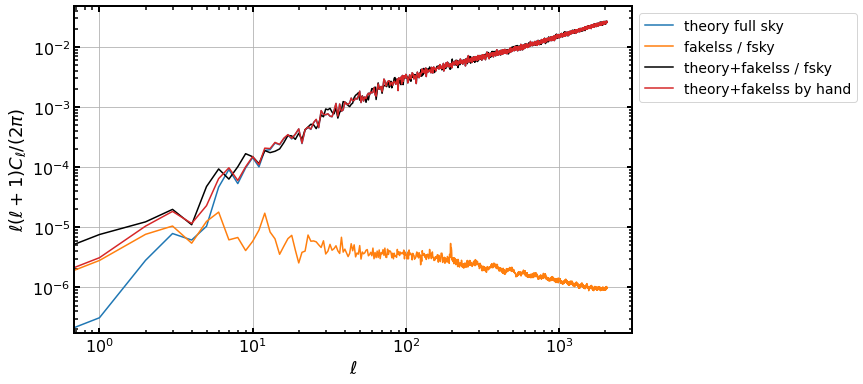

In [10]:
# lets create a log-log plot to see the scales a little more clearly
ells = np.arange(np.size(cls_fakelss))
fsky = len( np.where( fakelss['mask'] == False )[0] ) / len(fakelss['mask'])

# plot
plt.clf()
# theory spectrum
plt.plot(ells, (cls_theory * ells * (ells+1)) / 2.0 / np.pi, label='theory full sky')
# fakelss spectrum
plt.plot(ells, ( (cls_fakelss / fsky) * ells * (ells+1)) / 2.0 / np.pi, label='fakelss / fsky')
# new spectrum
plt.plot(ells, ( (cls_newmap / fsky) * ells * (ells+1)) / 2.0 / np.pi, color='k', label='theory+fakelss / fsky')
# expected new spectrum; note that we must account for the non-full-sky coverage in the survey map (fakelss).
plt.plot(ells, ( (cls_theory + cls_fakelss/fsky ) * ells * (ells+1)) / 2.0 / np.pi, color='#d62728', label='theory+fakelss by hand')
# plot details
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_\ell/(2\pi)$')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.show()

okay the red and black curves are similar - good; the curves should match if we consider different realizations. the fakelss appears to be important for only small ells.